In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import  preprocess_input

2024-07-04 07:48:39.334124: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 07:48:39.870127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 07:48:39.870165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 07:48:39.965839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 07:48:40.160022: I tensorflow/core/platform/cpu_feature_guar

In [2]:
src_path_train = "./Data_pet_CT/train/"
src_path_valid = "./Data_pet_CT/valid/"
src_path_test = "./Data_pet_CT/test/"

scale=1
rotation=20
# zoom=0.25
width_shift=0.25
height_shift=0.25
shear=0.25

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,
        rotation_range=rotation,
        # zoom_range=zoom,
        width_shift_range=width_shift,
        height_shift_range=width_shift,
        shear_range=shear,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,    
        dtype='float32',
        rescale=scale,) 

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,)

In [3]:
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory=src_path_valid,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 1099 images belonging to 4 classes.
Found 270 images belonging to 4 classes.
Found 139 images belonging to 4 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

In [5]:
NUM_CLASSES = 4

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
HIDDEN_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

BATCH_SIZE_TESTING = 1
STEPS_PER_EPOCH_TRAINING = int(train_generator.n / BATCH_SIZE) + 1
STEPS_PER_EPOCH_VALIDATION = int(valid_generator.n / BATCH_SIZE) + 1

In [15]:
model = Sequential()

model.add(ResNet50(
    include_top = False, 
    pooling = RESNET50_POOLING_AVERAGE,
    weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [16]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

In [17]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(
    learning_rate = 0.01, 
    momentum = 0.9, 
    nesterov = True)
model.compile(
    optimizer = sgd, 
    loss = 'categorical_crossentropy',
      metrics = ['accuracy'])

In [18]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

model_path = './models/TNM/model.hdf5'

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer = ModelCheckpoint(filepath = model_path, 
                                  monitor = 'val_loss', 
                                  save_best_only = False, 
                                  mode = 'auto')

In [ ]:
train_data = train_generator
valid_data = valid_generator

fit_history = model.fit(
        train_data,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 50,
        validation_data=valid_data,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[
            # cb_early_stopper, 
            cb_checkpointer]
)

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 1.0309 - accuracy: 0.6360

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 13s 287ms/step - loss: 1.0309 - accuracy: 0.6360 - val_loss: 0.6152 - val_accuracy: 0.7111
Epoch 2/50
35/35 [==============================] - 10s 286ms/step - loss: 0.6064 - accuracy: 0.7716 - val_loss: 0.6056 - val_accuracy: 0.7074
Epoch 3/50
35/35 [==============================] - 10s 282ms/step - loss: 0.5252 - accuracy: 0.7980 - val_loss: 0.3828 - val_accuracy: 0.8481
Epoch 4/50
35/35 [==============================] - 10s 278ms/step - loss: 0.3989 - accuracy: 0.8453 - val_loss: 0.3151 - val_accuracy: 0.8556
Epoch 5/50
35/35 [==============================] - 10s 283ms/step - loss: 0.4205 - accuracy: 0.8362 - val_loss: 0.2686 - val_accuracy: 0.9074
Epoch 6/50
35/35 [==============================] - 10s 273ms/step - loss: 0.3833 - accuracy: 0.8444 - val_loss: 0.3461 - val_accuracy: 0.8630
Epoch 7/50
35/35 [==============================] - 10s 274ms/step - loss: 0.3466 - accuracy: 0.8590 - val_loss: 0.1990 - val_accuracy: 0.9259
Epoch 8/50

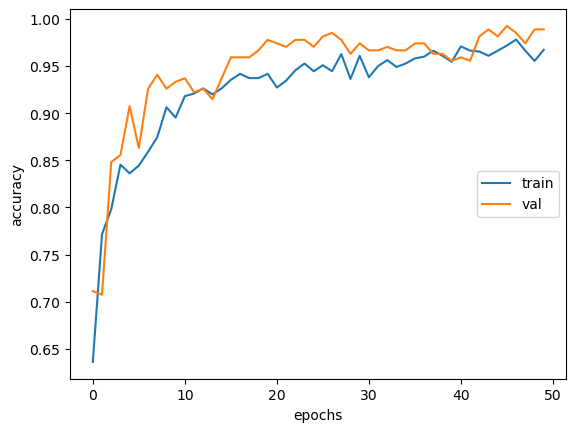

In [20]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

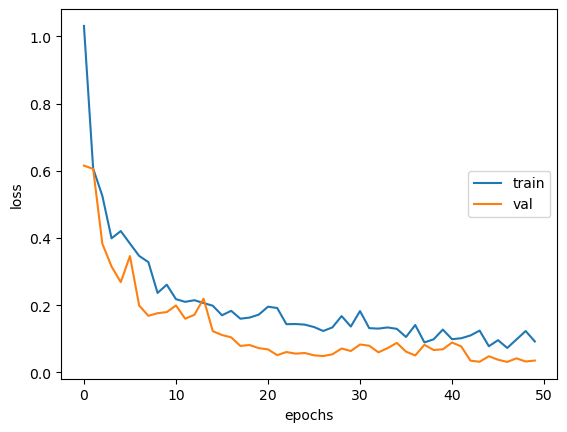

In [21]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [22]:
# model.load_weights(filepath='./models/best.hdf5')
model.evaluate(test_generator)

139/139 [==============================] - 2s 16ms/step - loss: 0.0839 - accuracy: 0.9712


[0.08386902511119843, 0.971222996711731]

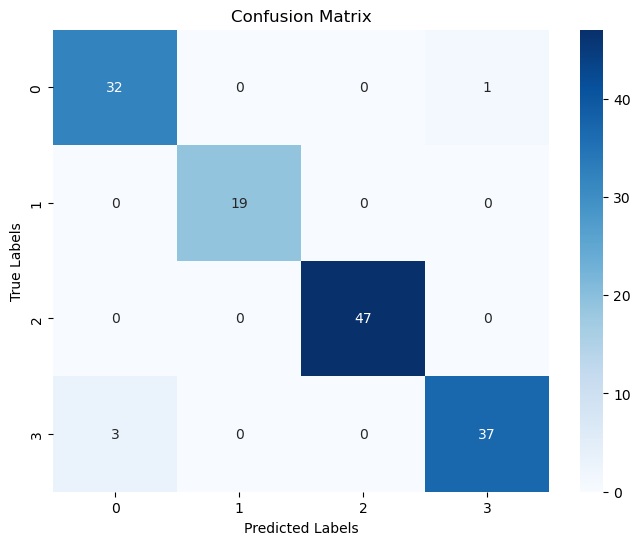

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = []
y_pred = []
res = model.predict(test_generator, verbose=0)
for i in range(test_generator.n):
    y_true.append(test_generator.labels[i])
    y_pred.append(np.argmax(res[i]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()